In [1]:
from nowcast_lstm.LSTM import LSTM
from nowcast_lstm.model_selection import variable_selection, hyperparameter_tuning, select_model
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import torch
import optuna

import seaborn as sns
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

c:\Users\lysov\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def gen_lagged_data(metadata, data, last_date, lag):
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# Data set up

In [3]:
data = pd.read_excel("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/data_tf.xlsx", decimal = ',', parse_dates=["date"])
metadata = pd.read_csv("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/meta_data.csv", delimiter = ";")
data_num = data.loc[:, data.columns != 'date']

target_variable = "gdp"

lags = list(range(-2, 3))

train_start_date = "2011-01-01"
train_end_date = "2018-12-01"
test_start_date = "2019-03-01"
test_end_date = "2023-09-01"

test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

In [4]:
def lags_selector(names: list, target:str, metadata: pd.DataFrame = metadata):
    """
    Возвращает массив с лагами переменных в соотвествующем порядке изначального массива имен `names`
    
    Параметры:
        `names`:массив с именами переменных
        `meta_data`: таблица с соотнесением факторов (их имен) и месячных лагов 
    """
    lags = []
    for name in names:
        if (name != 'date') and (name != target):
            lags.append(metadata[metadata['series'] == name].months_lag.iloc[0])
    return lags

In [199]:
# names = ['date', 'gdp',
#          # sectors
#          'agri', 'mining', 'manufacturing', 'egpiv', 'construction', 'trade', 'transport', 'finance', 'real_estate', 'others', 'taxes',
#          # PMI
#          'PMI_Mnf', 'PMI_Serv', 'PMI_Comp',
#          # IBC total
#          'IBC_total',  'IBC_total_fact', 'IBC_total_3m', 'IBC_total_output', 'IBC_total_output_3m', 'IBC_total_demand',
#          'IBC_total_demand_3m', 'IBC_total_price', 'IBC_total_price_3m','IBC_total_costs', 'IBC_total_credit',
#          # IBC ip
#          'IBC_ip', 'IBC_ip_fact', 'IBC_ip_3m', 'IBC_ip_output', 'IBC_ip_output_3m', 'IBC_ip_demand',
#          'IBC_ip_demand_3m', 'IBC_ip_price', 'IBC_ip_price_3m', 'IBC_ip_costs', 'IBC_ip_credit', 
#          # IBC mining
#          'IBC_mining', 'IBC_mining_fact', 'IBC_mining_3m', 'IBC_mining_output', 'IBC_mining_output_3m', 'IBC_mining_demand',
#          'IBC_mining_demand_3m', 'IBC_mining_price', 'IBC_mining_price_3m', 'IBC_mining_costs', 'IBC_mining_credit',
#          # IBC manufacturing
#          'IBC_mnf', 'IBC_mnf_fact', 'IBC_mnf_3m', 'IBC_mnf_output', 'IBC_mnf_output_3m', 'IBC_mnf_demand',
#          'IBC_mnf_demand_3m', 'IBC_mnf_price', 'IBC_mnf_price_3m', 'IBC_mnf_costs', 'IBC_mnf_credit',
#          # IBC constr
#          'IBC_constr', 'IBC_constr_fact', 'IBC_constr_3m', 'IBC_constr_output','IBC_constr_output_3m', 'IBC_constr_demand',
#          'IBC_constr_demand_3m', 'IBC_constr_price', 'IBC_constr_price_3m', 'IBC_constr_costs', 'IBC_constr_credit',
#          # IBC trade
#          'IBC_trade', 'IBC_trade_fact', 'IBC_trade_3m', 'IBC_trade_output', 'IBC_trade_output_3m', 'IBC_trade_demand',
#          'IBC_trade_demand_3m', 'IBC_trade_price', 'IBC_trade_price_3m', 'IBC_trade_costs', 'IBC_trade_credit',
#          # IBC transp
#          'IBC_transp', 'IBC_transp_fact', 'IBC_transp_3m', 'IBC_transp_output', 'IBC_transp_output_3m', 'IBC_transp_demand', 
#          'IBC_transp_demand_3m', 'IBC_transp_price', 'IBC_transp_price_3m', 'IBC_transp_costs', 'IBC_transp_credit',
#          # IBC serv
#          'IBC_serv', 'IBC_serv_fact', 'IBC_serv_3m', 'IBC_serv_output', 'IBC_serv_output_3m', 'IBC_serv_demand',
#          'IBC_serv_demand_3m', 'IBC_serv_price', 'IBC_serv_price_3m', 'IBC_serv_costs', 'IBC_serv_credit',
#          # hse + rspp
#          'hse', 'rspp1', 'rspp2', 'rspp3', 'rspp4', 'rspp5', 'rspp6', 'rspp7',
#          # ipu rosstat
#          'ipu_constr1', 'ipu_constr2', 'ipu_constr3',
#          # ip
#          'ip', 'ip_raw',  'ip_coal', 'ip_oil_products',
#          'ip_chemicals', 'ip_man', 'ip_metals', 'ip_constr', 'ip_cars', 'ip_food', 'ip_nonfood', 'ip_el',
#          # rail + cargo
#          'rail', 'cargo_rail', 'cargo_auto', 'cargo_sea', 'cargo_pipe',
#          # constr
#          'constr_vol', 'constr_prices',
#          # serv
#          'retail_prod', 'retail_neprod', 'opt', 'selhoz', 'pserv', 'obschepit',
#          # labor
#          'dispinc', 'eap', 'unemp', 'nwage', 'rwage', 
#          # cars and invest
#          'cars', 'trucks', 'iok', 'ibved',
#          # financial
#          'miacr', 'rtc', 'moex', 'reer', 'rvi', 'm0', 'm2x', 'ofz1', 'ofz3', 'ofz5', 'ofz10',
#          # dep/cred rates 
#          'dep_hh_rate', 'dep_nfo_rate', 'cred_hh_rate', 'cred_nfo_rate',
#          # ust
#          't2', 't10',
#          # external conditions
#          'ism_man', 'ism_serv', 'us_cpi', 'eu_cpi', 'cpi', 'cpi_prod', 'cpi_neprod', 'cpi_serv', 'ppi',
#          'brent', 'urals', 'aluminium', 'gold', 'gas',
#          # food prices
#          'FAOFOODI', 'FAOFCER', 'FAOFMEAT', 'FAOFDARY', 'FAOFSUGR', 'FAOFOILS']

# data = data.loc[:, names]
# # train and test datasets
# test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [5]:
corr = data_num.corr(method='pearson')

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data_num.columns[columns].insert(0, 'date')

data_selected = data.loc[:, selected_columns]
test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
names_selected = data_selected.columns.tolist()

In [6]:
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return p


In [7]:
data_num = data.loc[:, data.columns != 'date']
pvals = r_pvalues(data_num)

In [234]:
selected_columns = data_num.loc[:, pvals[target_variable] < 0.3].columns
selected_columns = selected_columns.insert(0, 'date')
data_selected_p = data.loc[:, selected_columns]
test_selected_p = data_selected_p.loc[(data_selected_p.date >= train_start_date) & (data_selected_p.date <= test_end_date), :].reset_index(drop=True)
names_selected_p = data_selected_p.columns.tolist()

In [8]:
def nowcast_lstm(model_params, target_variable, dates, actuals):
    
    selected_columns = data_num.loc[:, pvals[target_variable] < model_params['pval']].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected

    pred_dict = {k: [] for k in lags}
    try:
        for date in dates:
            train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:]
            
            model = LSTM(
                data = train,
                target_variable = target_variable,
                n_timesteps = model_params['n_timesteps'],
                fill_na_func = np.nanmean,
                fill_ragged_edges_func = np.nanmean, #np.nanmean, 'ARMA'
                n_models = 5,
                train_episodes = model_params["train_episodes"], # 50
                batch_size = model_params["batch_size"],
                decay = 0.98,
                n_hidden = model_params["n_hidden"],
                n_layers = model_params["n_layers"], #2
                dropout = 0, #0.02
                criterion = torch.nn.MSELoss(),
                optimizer = torch.optim.Adam,
                optimizer_parameters = {"lr":model_params["lr"], "weight_decay":0.0}
            )
            model.train(quiet=True)
            
            for lag in lags:
                tmp_data = gen_lagged_data(metadata, test_t, date, lag)
                
                pred = model.predict(data = tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
                pred_dict[lag].append(pred)
                  
        curr_MAE = np.mean(np.abs((np.array(actuals) - np.array(pred_dict[2]))))
    except: curr_MAE = 1000

    return curr_MAE

In [16]:
def objective(trial):
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    pval = trial.suggest_loguniform('pval', 1e-2, 1)
    n_timesteps = trial.suggest_categorical("n_timesteps", [1,3,6])
    train_episodes = trial.suggest_int("train_episodes", 25, 325, 50)
    batch_size = trial.suggest_int("batch_size", 64, 512, 32)
    n_hidden = trial.suggest_int('n_hidden', 25, 250, 25)
    n_layers = trial.suggest_int('n_layers', 1, 6, 1)
    lr = trial.suggest_categorical("lr", [1e-2])

    model_params = {'pval': pval, 'n_timesteps': n_timesteps, "train_episodes": train_episodes, "batch_size": batch_size,
                    "n_hidden": n_hidden, "n_layers": n_layers, "lr": lr}
    
    return nowcast_lstm(model_params, target_variable=target_variable, dates=dates, actuals=actuals)
    


In [10]:
def evaluate_lstm(data, model_params, target_variable, plot, save):
    target_variable = target_variable

    pval = model_params['pval']
    
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    selected_columns = data_num.loc[:, pvals[target_variable] < pval].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected
    
    pred_dict = {k: [] for k in lags}
    for date in dates:
        train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:]
        
        model = LSTM(
            data = train,
            target_variable = target_variable,
            n_timesteps = model_params['n_timesteps'],
            fill_na_func = np.nanmean,
            fill_ragged_edges_func = np.nanmean, #np.nanmean, 'ARMA'
            n_models = 5,
            train_episodes = model_params["train_episodes"], # 50
            batch_size = model_params["batch_size"],
            decay = 0.98,
            n_hidden = model_params["n_hidden"],
            n_layers = model_params["n_layers"], #2
            dropout = 0, #0.02
            criterion = torch.nn.MSELoss(),
            optimizer = torch.optim.Adam,
            optimizer_parameters = {"lr":model_params["lr"], "weight_decay":0.0}
        )
        model.train(quiet=True)
        
        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test_t, date, lag)
            
            pred = model.predict(data = tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
            pred_dict[lag].append(pred)
            
    performance = pd.DataFrame(columns=["Vintage", "RMSE", "MAE"])
    for lag in lags:
        tmp = pd.DataFrame({
            "Vintage":lag,
            "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
            "MAE":np.mean(np.abs((np.array(actuals) - np.array(pred_dict[lag]))))
        }, index=[0])
        performance = pd.concat([performance, tmp]).reset_index(drop=True)
    
    print(performance.round(4))

    if plot == 1:
        predictions_elastic = pd.DataFrame({
            "actuals":actuals, 
            "two_back":pred_dict[-2], 
            "one_back":pred_dict[-1], 
            "zero_back":pred_dict[0],
            "one_ahead":pred_dict[1],
            "two_ahead":pred_dict[2]}
        )
        predictions_elastic.plot()

    if save == 1:
        predictions_elastic.to_excel(f"predictions_{target_variable}_lstm.xlsx")
        

In [17]:
target_variable = 'gdp'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
gdp_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-30 21:13:08,126] A new study created in memory with name: no-name-3741633c-a695-4747-8ca7-193bce9aeb8a
[I 2024-04-30 21:14:05,813] Trial 0 finished with value: 1.5377497826867126 and parameters: {'pval': 0.02425044685309646, 'n_timesteps': 1, 'train_episodes': 25, 'batch_size': 352, 'n_hidden': 150, 'n_layers': 5, 'lr': 0.01}. Best is trial 0 with value: 1.5377497826867126.
[I 2024-04-30 21:16:37,117] Trial 1 finished with value: 1.953254263145199 and parameters: {'pval': 0.9732578304698614, 'n_timesteps': 6, 'train_episodes': 25, 'batch_size': 96, 'n_hidden': 250, 'n_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 1.5377497826867126.
[I 2024-04-30 21:18:28,930] Trial 2 finished with value: 1.4744010510430734 and parameters: {'pval': 0.23553401097808313, 'n_timesteps': 6, 'train_episodes': 175, 'batch_size': 352, 'n_hidden': 50, 'n_layers': 1, 'lr': 0.01}. Best is trial 2 with value: 1.4744010510430734.
[I 2024-04-30 21:21:42,152] Trial 3 finished with value: 1.37388457

Best MAE=1.201118721271703, best parameters:{'pval': 0.013503054305734598, 'n_timesteps': 3, 'train_episodes': 275, 'batch_size': 64, 'n_hidden': 250, 'n_layers': 2, 'lr': 0.01}


In [18]:
optuna.visualization.plot_optimization_history(study)

  Vintage    RMSE     MAE
0      -2  2.8419  1.7061
1      -1  2.8419  1.7061
2       0  2.2358  1.3352
3       1  2.0677  1.2864
4       2  2.0157  1.2569


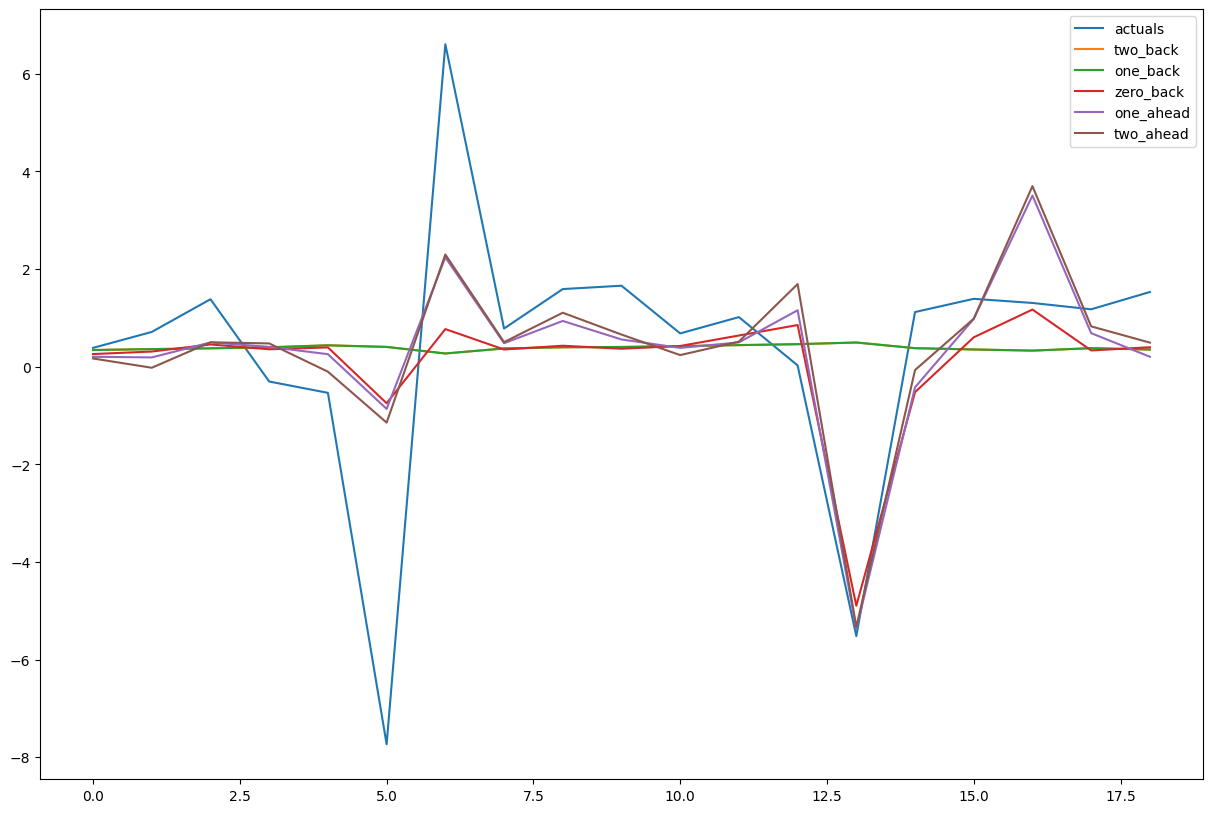

In [20]:
evaluate_lstm(data = data, target_variable='gdp', model_params=gdp_opt, plot=1, save=1)

In [21]:
target_variable = 'agri'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
agri_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-02 00:20:53,769] A new study created in memory with name: no-name-a40d1528-e163-4569-82ba-9745218e928a
[I 2024-05-02 00:26:10,204] Trial 0 finished with value: 0.6839927423813754 and parameters: {'pval': 0.35957906066423256, 'n_timesteps': 1, 'train_episodes': 275, 'batch_size': 416, 'n_hidden': 250, 'n_layers': 2, 'lr': 0.01}. Best is trial 0 with value: 0.6839927423813754.
[I 2024-05-02 00:26:44,838] Trial 1 finished with value: 0.45079981586849793 and parameters: {'pval': 0.049869745933221854, 'n_timesteps': 6, 'train_episodes': 75, 'batch_size': 512, 'n_hidden': 100, 'n_layers': 1, 'lr': 0.01}. Best is trial 1 with value: 0.45079981586849793.
[I 2024-05-02 00:35:51,600] Trial 2 finished with value: 0.6610096988714643 and parameters: {'pval': 0.24256910654441394, 'n_timesteps': 3, 'train_episodes': 175, 'batch_size': 128, 'n_hidden': 225, 'n_layers': 6, 'lr': 0.01}. Best is trial 1 with value: 0.45079981586849793.
[I 2024-05-02 00:37:12,387] Trial 3 finished with value: 0

Best MAE=0.3005212930071284, best parameters:{'pval': 0.3437863656972774, 'n_timesteps': 6, 'train_episodes': 25, 'batch_size': 480, 'n_hidden': 250, 'n_layers': 1, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  0.4287  0.3148
1      -1  0.4329  0.3202
2       0  0.4367  0.3211
3       1  0.4386  0.3161
4       2  0.4310  0.3187


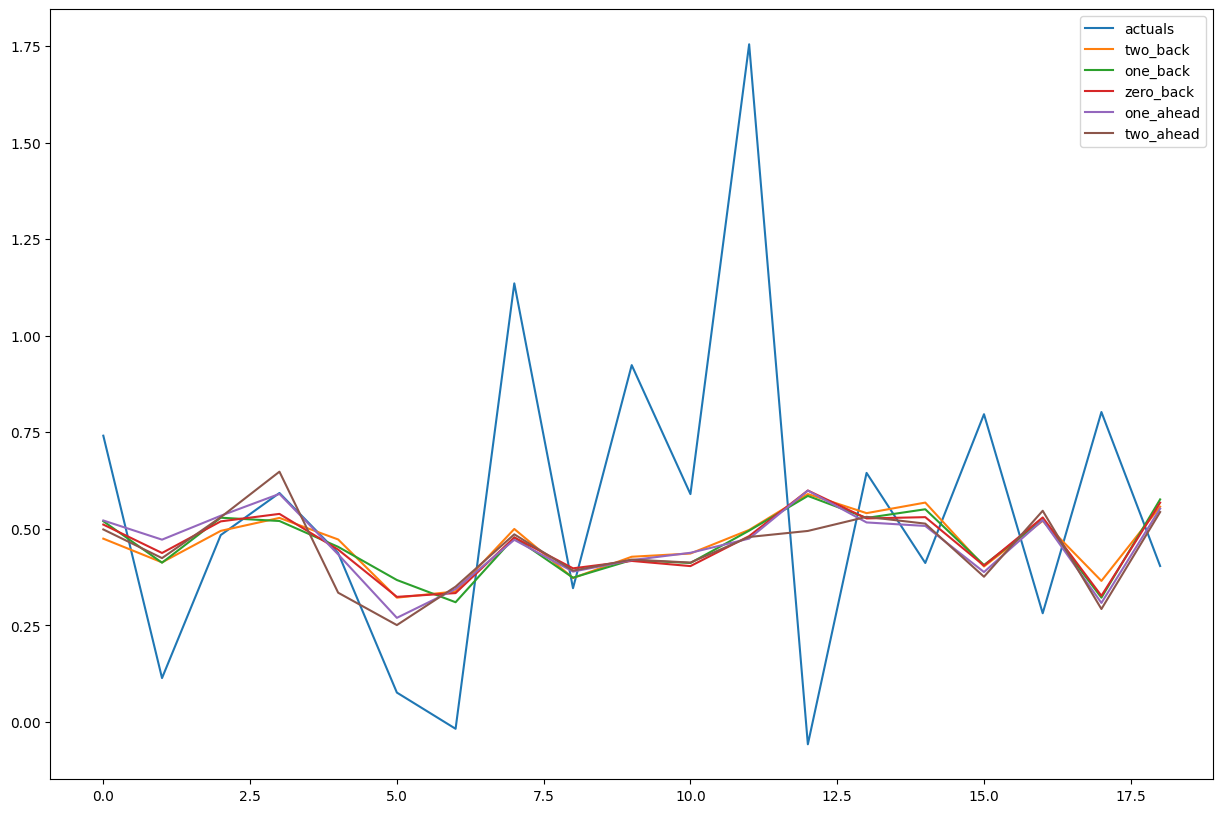

In [22]:
evaluate_lstm(data = data, target_variable='agri', model_params=agri_opt, plot=1, save=1)

In [23]:
target_variable = 'mining'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
mining_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-02 03:06:20,953] A new study created in memory with name: no-name-dc1cd9a6-c764-4015-abe0-ca2fe9c473ad
[I 2024-05-02 03:06:45,857] Trial 0 finished with value: 2.1052228723452613 and parameters: {'pval': 0.01742287898310861, 'n_timesteps': 3, 'train_episodes': 25, 'batch_size': 160, 'n_hidden': 100, 'n_layers': 1, 'lr': 0.01}. Best is trial 0 with value: 2.1052228723452613.
[I 2024-05-02 03:07:30,481] Trial 1 finished with value: 2.113390778116886 and parameters: {'pval': 0.027335881960245226, 'n_timesteps': 3, 'train_episodes': 25, 'batch_size': 448, 'n_hidden': 150, 'n_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 2.1052228723452613.
[I 2024-05-02 03:09:05,442] Trial 2 finished with value: 2.4065018727288403 and parameters: {'pval': 0.04535017565704838, 'n_timesteps': 6, 'train_episodes': 75, 'batch_size': 352, 'n_hidden': 75, 'n_layers': 4, 'lr': 0.01}. Best is trial 0 with value: 2.1052228723452613.
[I 2024-05-02 03:17:16,316] Trial 3 finished with value: 2.556933

Best MAE=1.7874997350811008, best parameters:{'pval': 0.032549917436519527, 'n_timesteps': 1, 'train_episodes': 275, 'batch_size': 320, 'n_hidden': 150, 'n_layers': 2, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  3.3326  2.1177
1      -1  3.3326  2.1177
2       0  3.3326  2.1177
3       1  3.3326  2.1177
4       2  2.7030  1.8834


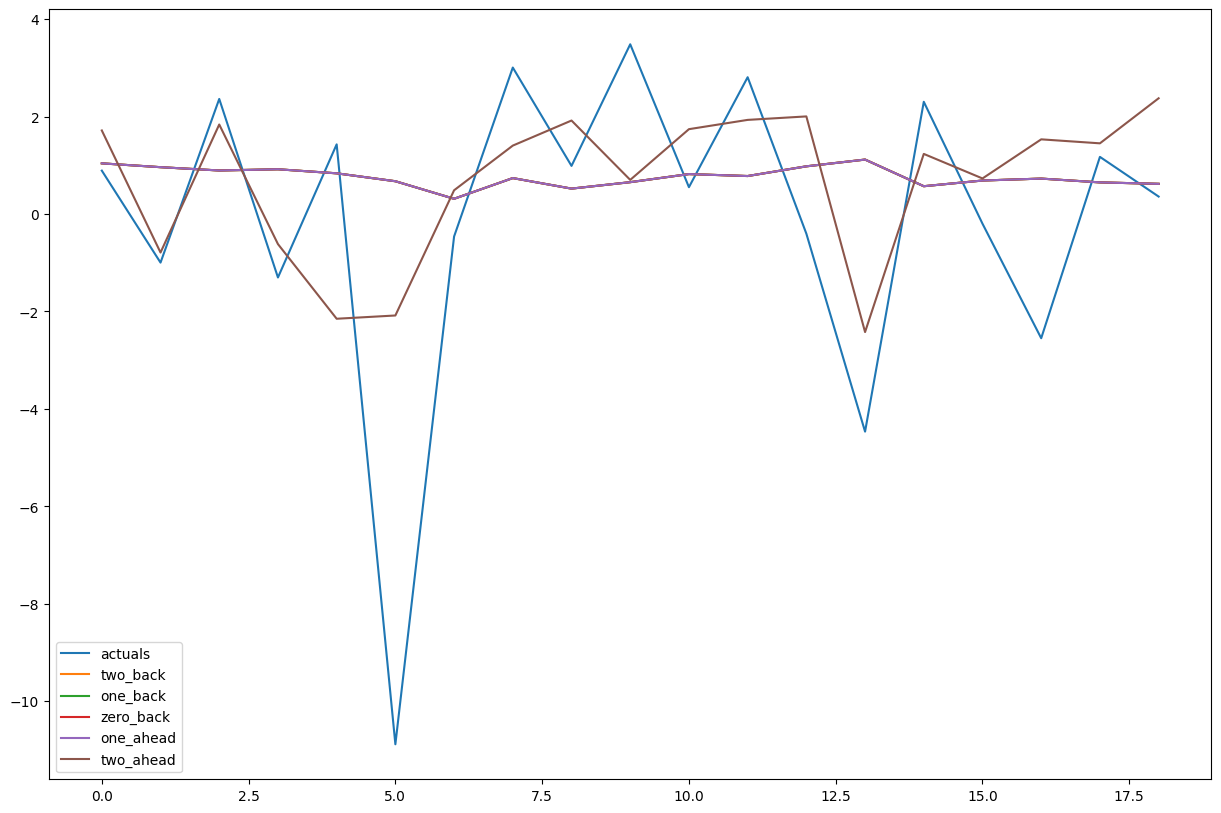

In [24]:
evaluate_lstm(data = data, target_variable='mining', model_params=mining_opt, plot=1, save=1)

In [25]:
target_variable = 'manufacturing'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
manufacturing_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-02 07:28:07,286] A new study created in memory with name: no-name-f0b594c7-5939-4b38-857e-4ad757f24dff
[I 2024-05-02 07:31:12,264] Trial 0 finished with value: 2.304355870664947 and parameters: {'pval': 0.8049251094363317, 'n_timesteps': 6, 'train_episodes': 125, 'batch_size': 352, 'n_hidden': 75, 'n_layers': 4, 'lr': 0.01}. Best is trial 0 with value: 2.304355870664947.
[I 2024-05-02 07:33:31,651] Trial 1 finished with value: 2.1776754785373256 and parameters: {'pval': 0.023499692743848794, 'n_timesteps': 1, 'train_episodes': 325, 'batch_size': 256, 'n_hidden': 200, 'n_layers': 1, 'lr': 0.01}. Best is trial 1 with value: 2.1776754785373256.
[I 2024-05-02 07:41:09,703] Trial 2 finished with value: 2.9824801483184453 and parameters: {'pval': 0.14314487871454026, 'n_timesteps': 1, 'train_episodes': 325, 'batch_size': 128, 'n_hidden': 150, 'n_layers': 5, 'lr': 0.01}. Best is trial 1 with value: 2.1776754785373256.
[I 2024-05-02 07:45:03,241] Trial 3 finished with value: 2.64517

Best MAE=1.7643806249215954, best parameters:{'pval': 0.2532123240383234, 'n_timesteps': 6, 'train_episodes': 125, 'batch_size': 160, 'n_hidden': 75, 'n_layers': 3, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  2.5833  1.7669
1      -1  2.7018  1.7977
2       0  2.5879  1.7147
3       1  2.5333  1.6815
4       2  2.5567  1.7245


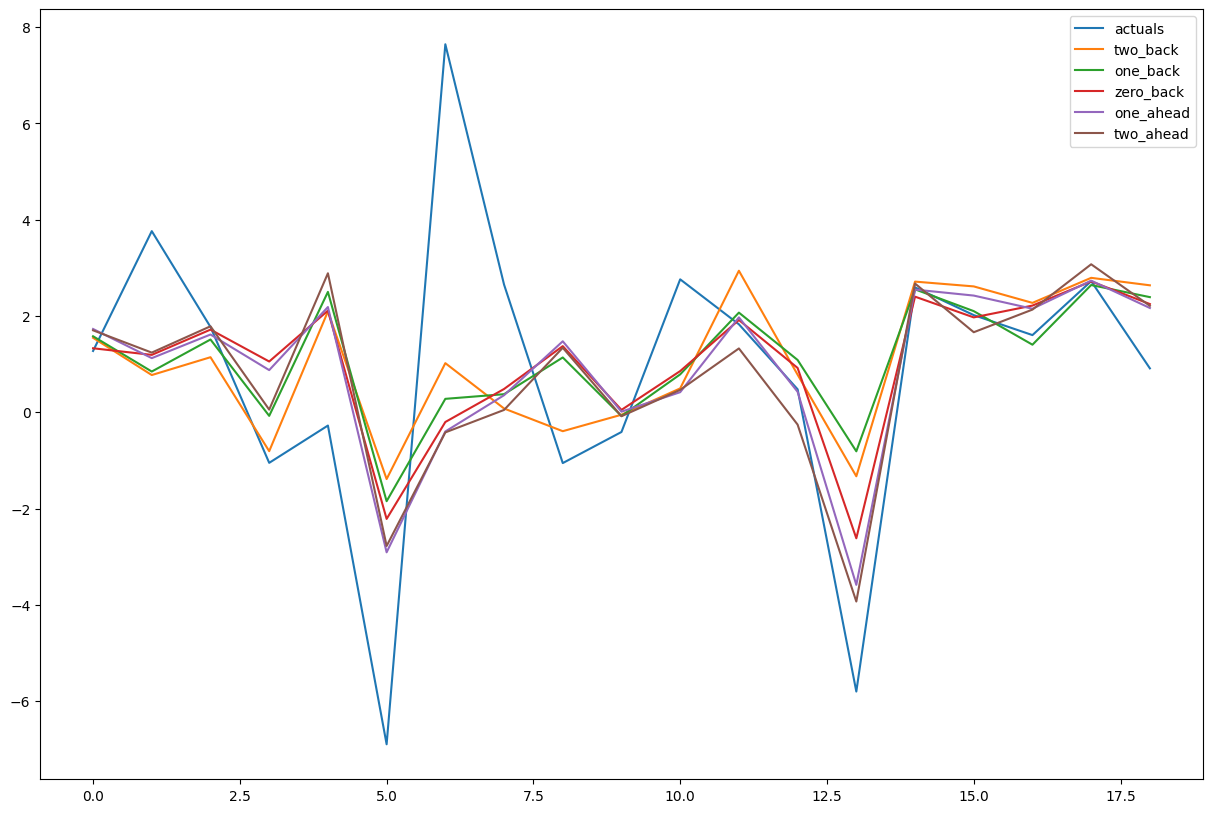

In [26]:
evaluate_lstm(data = data, target_variable='manufacturing', model_params=manufacturing_opt, plot=1, save=1)

In [27]:
target_variable = 'egpiv'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
egpiv_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-02 13:50:47,648] A new study created in memory with name: no-name-3df14e89-1eac-4b1d-80f4-6d6754e16844
[I 2024-05-02 13:53:06,638] Trial 0 finished with value: 1.0927747232199092 and parameters: {'pval': 0.1509481864981866, 'n_timesteps': 1, 'train_episodes': 75, 'batch_size': 288, 'n_hidden': 150, 'n_layers': 5, 'lr': 0.01}. Best is trial 0 with value: 1.0927747232199092.
[I 2024-05-02 13:57:53,786] Trial 1 finished with value: 1.0408792634563222 and parameters: {'pval': 0.15643213297859734, 'n_timesteps': 3, 'train_episodes': 225, 'batch_size': 384, 'n_hidden': 125, 'n_layers': 4, 'lr': 0.01}. Best is trial 1 with value: 1.0408792634563222.
[I 2024-05-02 14:03:04,685] Trial 2 finished with value: 1.1501763267213818 and parameters: {'pval': 0.19152975543078282, 'n_timesteps': 1, 'train_episodes': 275, 'batch_size': 480, 'n_hidden': 75, 'n_layers': 6, 'lr': 0.01}. Best is trial 1 with value: 1.0408792634563222.
[I 2024-05-02 14:10:25,158] Trial 3 finished with value: 0.99466

Best MAE=0.7790170365378589, best parameters:{'pval': 0.06094467009057894, 'n_timesteps': 6, 'train_episodes': 175, 'batch_size': 448, 'n_hidden': 125, 'n_layers': 3, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  1.3616  0.9900
1      -1  1.2626  0.9200
2       0  1.2454  0.9641
3       1  1.1711  0.8578
4       2  1.0258  0.7933


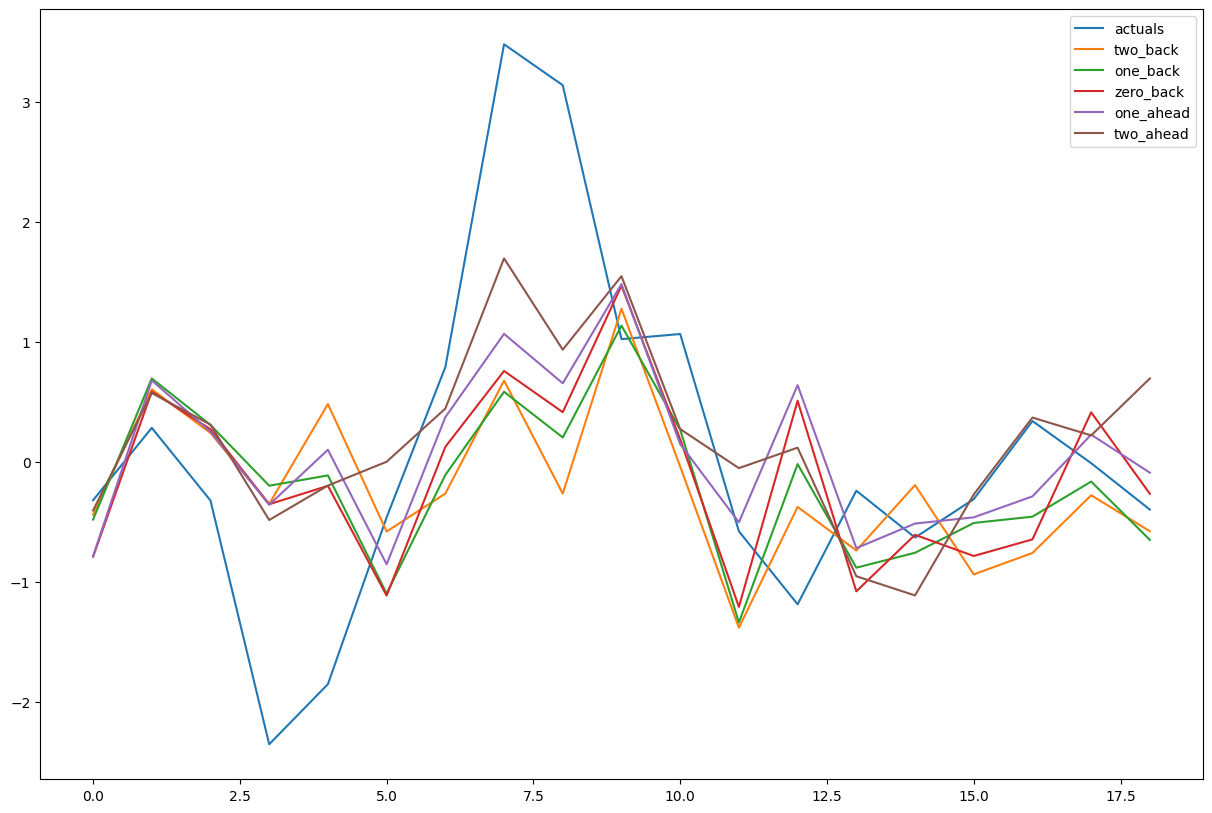

In [28]:
evaluate_lstm(data = data, target_variable='egpiv', model_params=egpiv_opt, plot=1, save=1)

In [29]:
target_variable = 'construction'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
construction_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-02 17:35:23,891] A new study created in memory with name: no-name-00ffd263-996d-4c63-8be6-07bfb2f778ea
[I 2024-05-02 17:38:17,197] Trial 0 finished with value: 3.742994017785425 and parameters: {'pval': 0.02005007622709715, 'n_timesteps': 1, 'train_episodes': 225, 'batch_size': 448, 'n_hidden': 75, 'n_layers': 4, 'lr': 0.01}. Best is trial 0 with value: 3.742994017785425.
[I 2024-05-02 17:39:32,697] Trial 1 finished with value: 4.279860924361119 and parameters: {'pval': 0.061781363512794785, 'n_timesteps': 6, 'train_episodes': 75, 'batch_size': 224, 'n_hidden': 50, 'n_layers': 5, 'lr': 0.01}. Best is trial 0 with value: 3.742994017785425.
[I 2024-05-02 17:43:52,330] Trial 2 finished with value: 3.951129665463211 and parameters: {'pval': 0.8196111560120485, 'n_timesteps': 1, 'train_episodes': 225, 'batch_size': 96, 'n_hidden': 100, 'n_layers': 4, 'lr': 0.01}. Best is trial 0 with value: 3.742994017785425.
[I 2024-05-02 17:53:22,612] Trial 3 finished with value: 4.171443063150

Best MAE=2.8023426073691784, best parameters:{'pval': 0.4171147789618064, 'n_timesteps': 1, 'train_episodes': 125, 'batch_size': 384, 'n_hidden': 50, 'n_layers': 1, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  4.2082  3.6035
1      -1  4.2082  3.6035
2       0  4.2082  3.6035
3       1  4.2082  3.6035
4       2  3.4989  2.8693


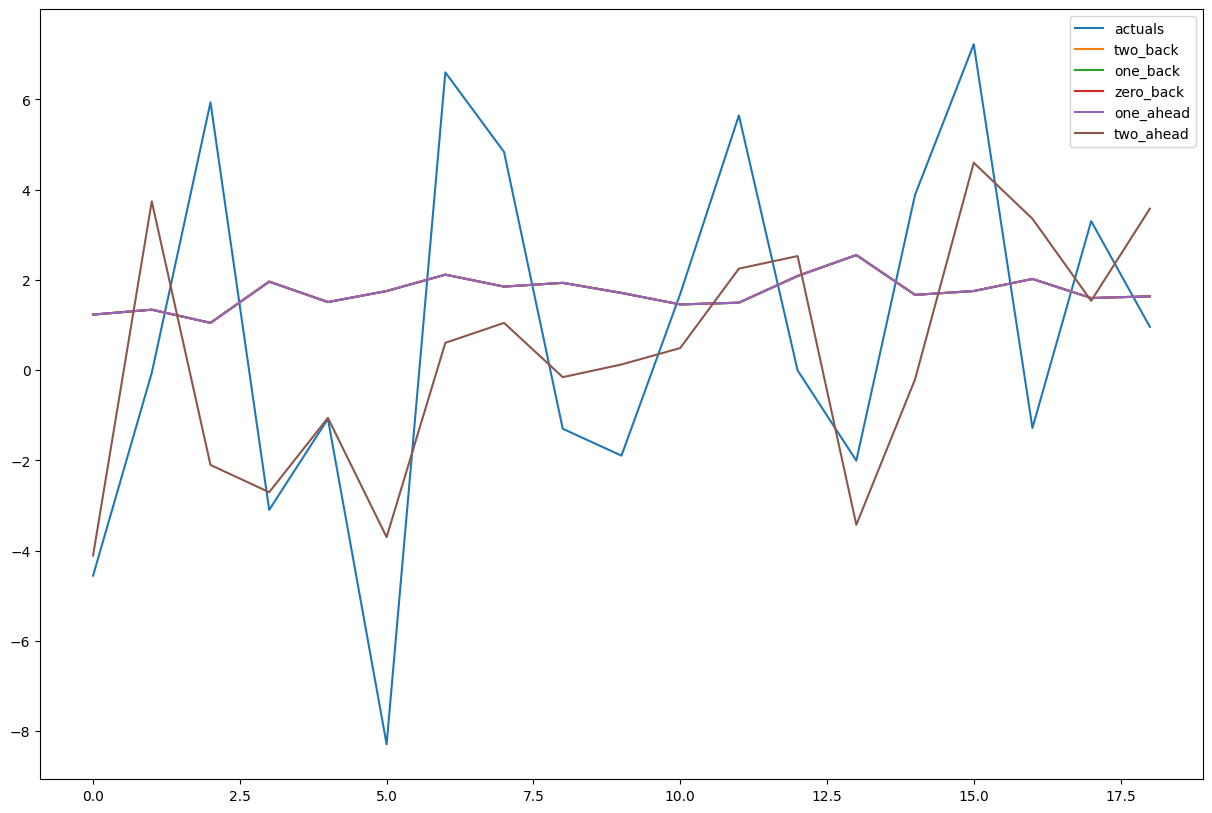

In [30]:
evaluate_lstm(data = data, target_variable='construction', model_params=construction_opt, plot=1, save=1)

In [31]:
target_variable = 'trade'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
trade_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-02 23:20:36,321] A new study created in memory with name: no-name-7e1db371-7ea1-4c36-80c2-3b9fea308945
[I 2024-05-02 23:24:19,958] Trial 0 finished with value: 5.1083914796906225 and parameters: {'pval': 0.054470645965881935, 'n_timesteps': 1, 'train_episodes': 275, 'batch_size': 384, 'n_hidden': 75, 'n_layers': 4, 'lr': 0.01}. Best is trial 0 with value: 5.1083914796906225.
[I 2024-05-02 23:27:06,820] Trial 1 finished with value: 4.2483979346876835 and parameters: {'pval': 0.018857076622018982, 'n_timesteps': 6, 'train_episodes': 175, 'batch_size': 512, 'n_hidden': 100, 'n_layers': 3, 'lr': 0.01}. Best is trial 1 with value: 4.2483979346876835.
[I 2024-05-02 23:30:30,065] Trial 2 finished with value: 5.138230372884532 and parameters: {'pval': 0.9045343697570151, 'n_timesteps': 1, 'train_episodes': 225, 'batch_size': 160, 'n_hidden': 225, 'n_layers': 1, 'lr': 0.01}. Best is trial 1 with value: 4.2483979346876835.
[I 2024-05-02 23:35:47,437] Trial 3 finished with value: 4.774

Best MAE=3.2821832640588715, best parameters:{'pval': 0.12058711906851652, 'n_timesteps': 3, 'train_episodes': 25, 'batch_size': 96, 'n_hidden': 225, 'n_layers': 2, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  6.9171  4.5619
1      -1  6.9171  4.5619
2       0  5.1172  3.5677
3       1  4.9504  3.3445
4       2  4.9243  3.3777


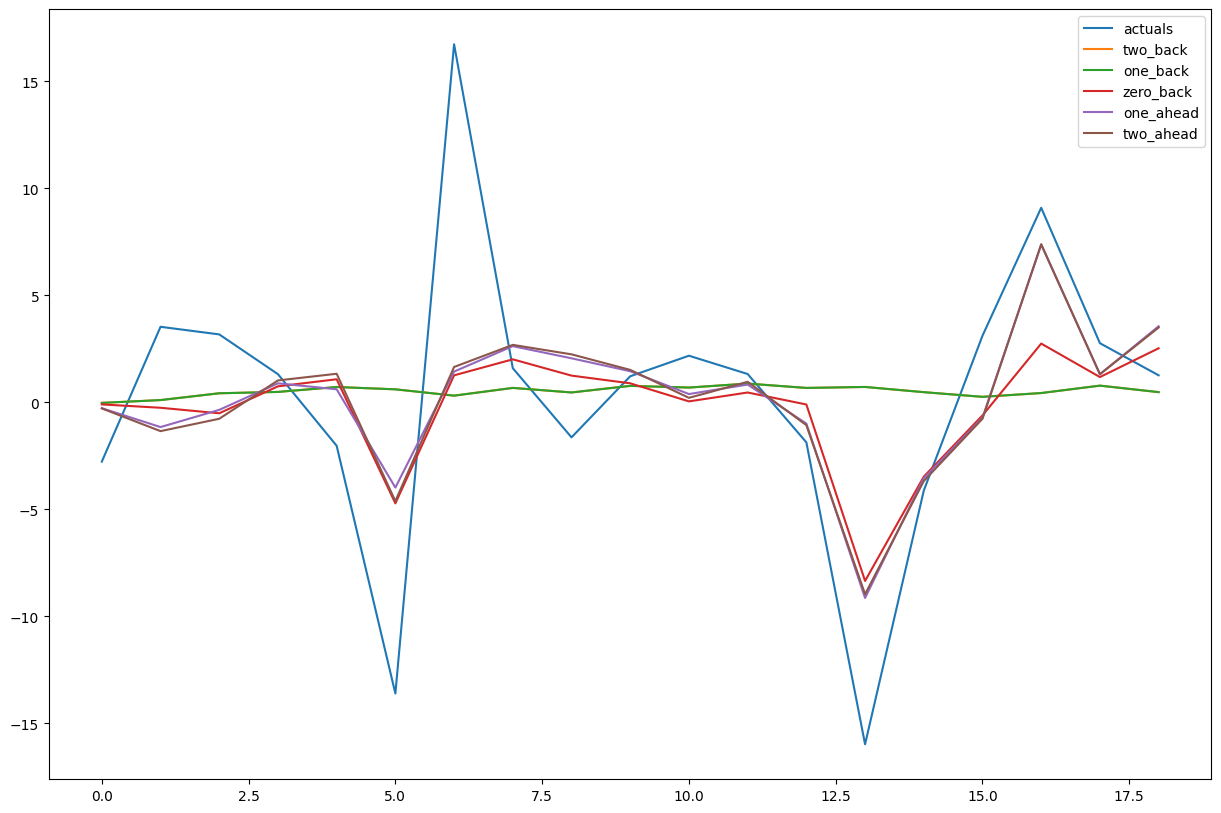

In [32]:
evaluate_lstm(data = data, target_variable='trade', model_params=trade_opt, plot=1, save=1)

In [33]:
target_variable = 'transport'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
transport_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 03:54:46,019] A new study created in memory with name: no-name-3f405228-ed73-40cc-b7b4-10dae7210e21
[I 2024-05-03 03:56:36,262] Trial 0 finished with value: 2.3263332367095737 and parameters: {'pval': 0.02701710923977996, 'n_timesteps': 1, 'train_episodes': 175, 'batch_size': 192, 'n_hidden': 75, 'n_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 2.3263332367095737.
[I 2024-05-03 03:59:49,450] Trial 1 finished with value: 2.9424969290967296 and parameters: {'pval': 0.5056144848150006, 'n_timesteps': 3, 'train_episodes': 275, 'batch_size': 96, 'n_hidden': 50, 'n_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 2.3263332367095737.
[I 2024-05-03 04:01:34,192] Trial 2 finished with value: 2.188792003784861 and parameters: {'pval': 0.012167231933797954, 'n_timesteps': 1, 'train_episodes': 175, 'batch_size': 320, 'n_hidden': 125, 'n_layers': 2, 'lr': 0.01}. Best is trial 2 with value: 2.188792003784861.
[I 2024-05-03 04:04:19,222] Trial 3 finished with value: 2.5949851

Best MAE=2.0884270671971263, best parameters:{'pval': 0.1790041112094083, 'n_timesteps': 1, 'train_episodes': 175, 'batch_size': 384, 'n_hidden': 250, 'n_layers': 6, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  4.7107  2.5254
1      -1  4.7107  2.5254
2       0  4.7107  2.5254
3       1  4.7107  2.5254
4       2  3.9701  2.1111


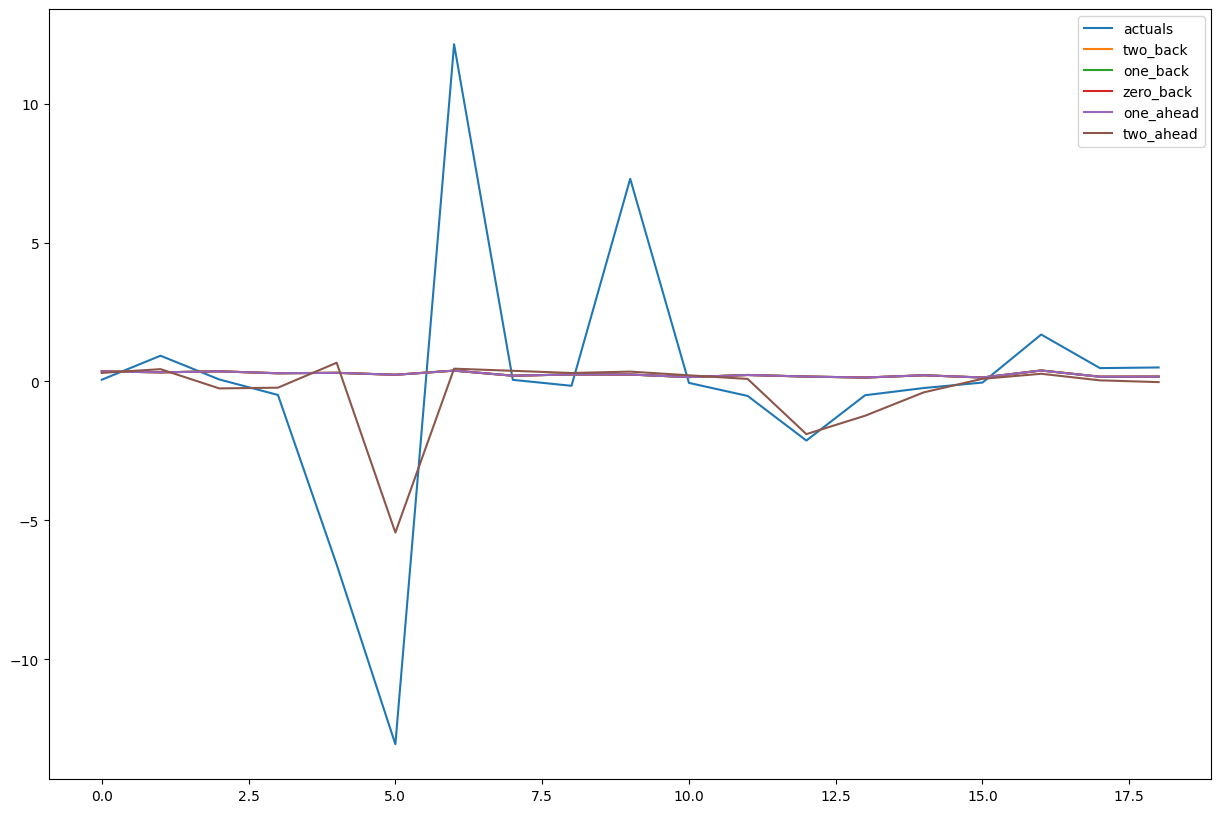

In [34]:
evaluate_lstm(data = data, target_variable='transport', model_params=transport_opt, plot=1, save=1)

In [35]:
target_variable = 'finance'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
finance_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 14:17:17,743] A new study created in memory with name: no-name-e4097e1d-2665-4da1-a64d-d25ed6658131
[I 2024-05-03 14:21:24,999] Trial 0 finished with value: 2.6588953762510714 and parameters: {'pval': 0.01068152216020884, 'n_timesteps': 3, 'train_episodes': 275, 'batch_size': 512, 'n_hidden': 100, 'n_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 2.6588953762510714.
[I 2024-05-03 14:26:26,831] Trial 1 finished with value: 2.6467327519719785 and parameters: {'pval': 0.384265390578557, 'n_timesteps': 6, 'train_episodes': 225, 'batch_size': 256, 'n_hidden': 175, 'n_layers': 2, 'lr': 0.01}. Best is trial 1 with value: 2.6467327519719785.
[I 2024-05-03 14:31:04,606] Trial 2 finished with value: 2.5546082828998644 and parameters: {'pval': 0.1745384507813893, 'n_timesteps': 3, 'train_episodes': 125, 'batch_size': 160, 'n_hidden': 250, 'n_layers': 3, 'lr': 0.01}. Best is trial 2 with value: 2.5546082828998644.
[I 2024-05-03 14:36:33,710] Trial 3 finished with value: 2.68773

Best MAE=1.5816251097164882, best parameters:{'pval': 0.11831113307577366, 'n_timesteps': 6, 'train_episodes': 25, 'batch_size': 64, 'n_hidden': 250, 'n_layers': 1, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  2.2825  1.7409
1      -1  2.2551  1.7505
2       0  2.2383  1.7463
3       1  2.2359  1.7211
4       2  2.2273  1.6697


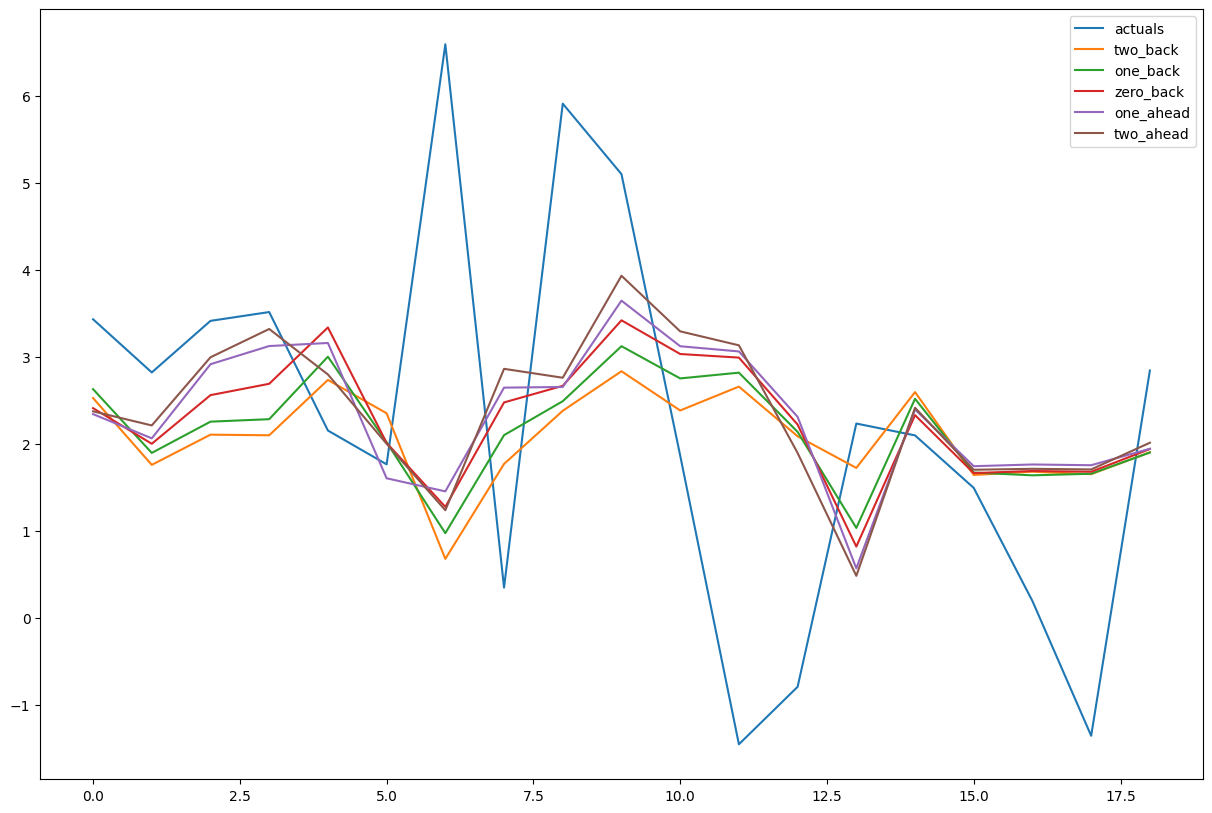

In [43]:
evaluate_lstm(data = data, target_variable='finance', model_params=finance_opt, plot=1, save=1)

In [37]:
target_variable = 'real_estate'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
real_estate_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 16:57:46,127] A new study created in memory with name: no-name-5603dd60-6511-4c29-b0d8-08b62ad2ba47
[I 2024-05-03 16:59:32,101] Trial 0 finished with value: 1.0971198239716649 and parameters: {'pval': 0.5053355451676926, 'n_timesteps': 1, 'train_episodes': 75, 'batch_size': 288, 'n_hidden': 100, 'n_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 1.0971198239716649.
[I 2024-05-03 17:01:29,875] Trial 1 finished with value: 1.0497566176196067 and parameters: {'pval': 0.06096443193432107, 'n_timesteps': 1, 'train_episodes': 125, 'batch_size': 288, 'n_hidden': 50, 'n_layers': 5, 'lr': 0.01}. Best is trial 1 with value: 1.0497566176196067.
[I 2024-05-03 17:02:06,917] Trial 2 finished with value: 1.0749594420678101 and parameters: {'pval': 0.19267761944594045, 'n_timesteps': 3, 'train_episodes': 25, 'batch_size': 480, 'n_hidden': 100, 'n_layers': 1, 'lr': 0.01}. Best is trial 1 with value: 1.0497566176196067.
[I 2024-05-03 17:05:05,548] Trial 3 finished with value: 1.204893

Best MAE=0.85412705681039, best parameters:{'pval': 0.01867810002002154, 'n_timesteps': 1, 'train_episodes': 175, 'batch_size': 64, 'n_hidden': 200, 'n_layers': 6, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  1.3675  0.9842
1      -1  1.3675  0.9842
2       0  1.3675  0.9842
3       1  1.3675  0.9842
4       2  1.2106  0.8805


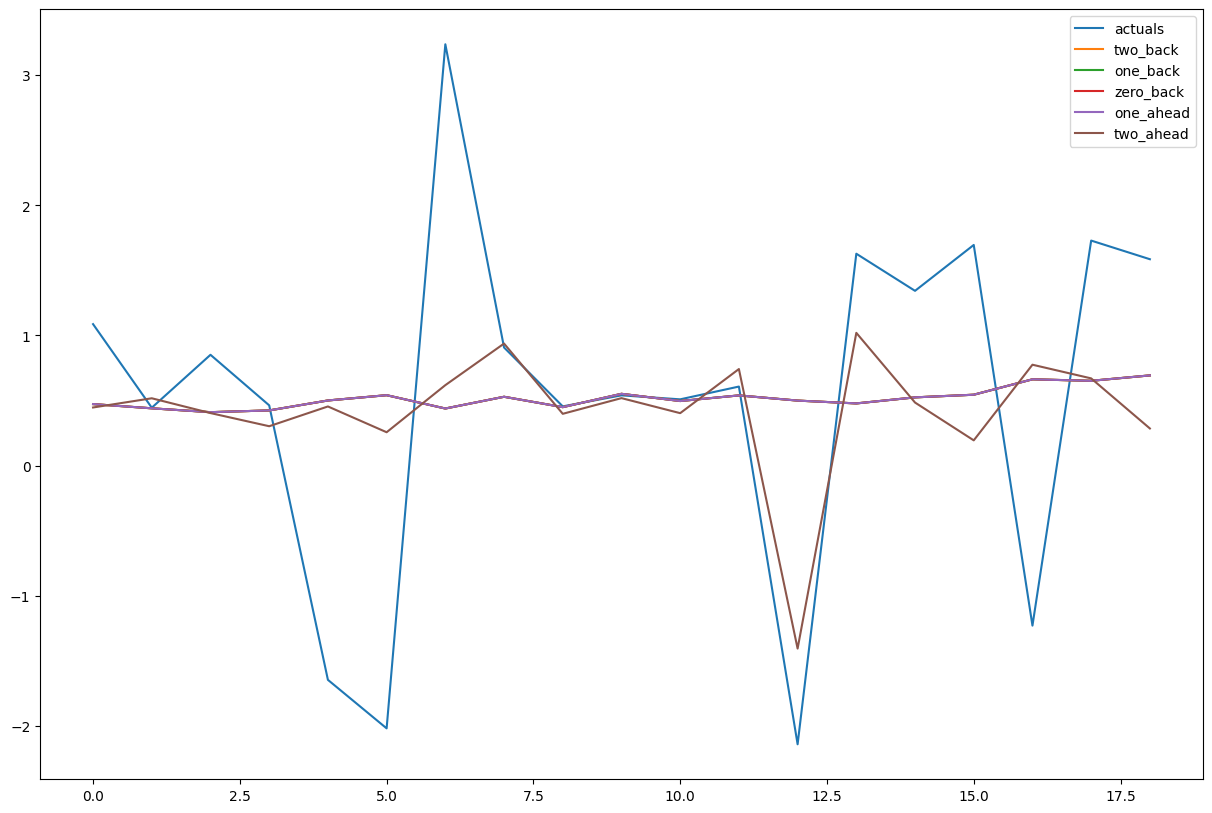

In [38]:
evaluate_lstm(data = data, target_variable='real_estate', model_params=real_estate_opt, plot=1, save=1)

In [39]:
target_variable = 'others'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
others_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-04 03:23:50,014] A new study created in memory with name: no-name-40c6b077-b707-41aa-b948-2451e3d31c2b
[I 2024-05-04 03:38:08,770] Trial 0 finished with value: 4.02091688657454 and parameters: {'pval': 0.01895868183940649, 'n_timesteps': 6, 'train_episodes': 275, 'batch_size': 64, 'n_hidden': 200, 'n_layers': 6, 'lr': 0.01}. Best is trial 0 with value: 4.02091688657454.
[I 2024-05-04 03:40:37,811] Trial 1 finished with value: 3.361889208039959 and parameters: {'pval': 0.20827617751019153, 'n_timesteps': 6, 'train_episodes': 275, 'batch_size': 416, 'n_hidden': 50, 'n_layers': 2, 'lr': 0.01}. Best is trial 1 with value: 3.361889208039959.
[I 2024-05-04 03:42:47,813] Trial 2 finished with value: 3.6567693412244564 and parameters: {'pval': 0.9468245018297407, 'n_timesteps': 1, 'train_episodes': 175, 'batch_size': 416, 'n_hidden': 75, 'n_layers': 1, 'lr': 0.01}. Best is trial 1 with value: 3.361889208039959.
[I 2024-05-04 03:47:08,285] Trial 3 finished with value: 3.2945844326546

Best MAE=2.469524436011754, best parameters:{'pval': 0.024205619102015907, 'n_timesteps': 6, 'train_episodes': 175, 'batch_size': 384, 'n_hidden': 250, 'n_layers': 1, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  4.4795  3.0157
1      -1  4.3948  2.9385
2       0  4.2195  2.8735
3       1  3.9544  2.8004
4       2  3.6175  2.5700


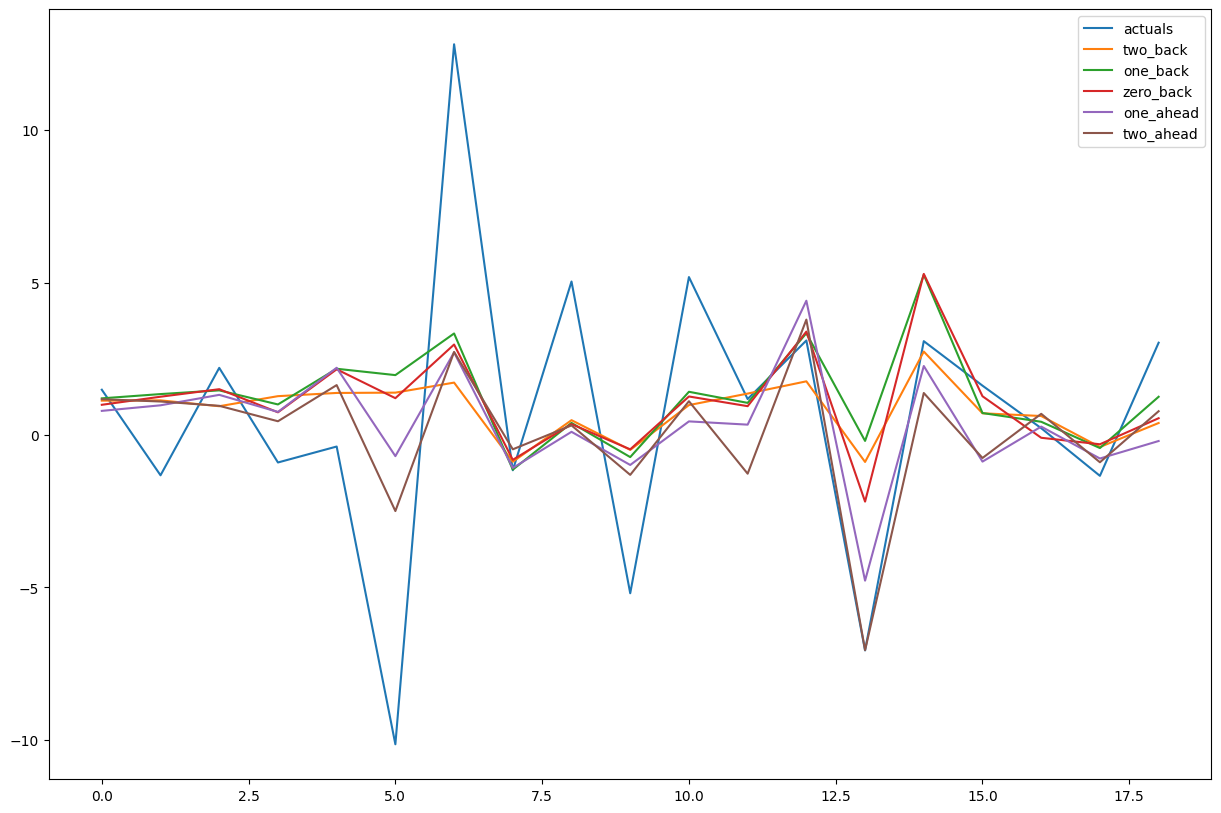

In [40]:
evaluate_lstm(data = data, target_variable='others', model_params=others_opt, plot=1, save=1)

In [41]:
target_variable = 'taxes'
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
taxes_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-04 11:08:36,060] A new study created in memory with name: no-name-e4715a40-ef19-4d48-a908-1ddf5bf3a407
[I 2024-05-04 11:14:17,908] Trial 0 finished with value: 2.495929096098799 and parameters: {'pval': 0.016681187138143715, 'n_timesteps': 3, 'train_episodes': 275, 'batch_size': 480, 'n_hidden': 125, 'n_layers': 4, 'lr': 0.01}. Best is trial 0 with value: 2.495929096098799.
[I 2024-05-04 11:18:20,989] Trial 1 finished with value: 2.6242000019363787 and parameters: {'pval': 0.06893126811633885, 'n_timesteps': 1, 'train_episodes': 75, 'batch_size': 160, 'n_hidden': 250, 'n_layers': 5, 'lr': 0.01}. Best is trial 0 with value: 2.495929096098799.
[I 2024-05-04 11:23:41,634] Trial 2 finished with value: 2.3049181609082754 and parameters: {'pval': 0.045285997929424136, 'n_timesteps': 3, 'train_episodes': 275, 'batch_size': 256, 'n_hidden': 150, 'n_layers': 3, 'lr': 0.01}. Best is trial 2 with value: 2.3049181609082754.
[I 2024-05-04 11:27:49,080] Trial 3 finished with value: 2.4547

Best MAE=1.9465073790238092, best parameters:{'pval': 0.10553179299276329, 'n_timesteps': 3, 'train_episodes': 175, 'batch_size': 352, 'n_hidden': 250, 'n_layers': 2, 'lr': 0.01}


  Vintage    RMSE     MAE
0      -2  4.1128  2.5921
1      -1  4.1128  2.5921
2       0  3.3676  2.2654
3       1  3.3266  2.1354
4       2  3.1583  2.0380


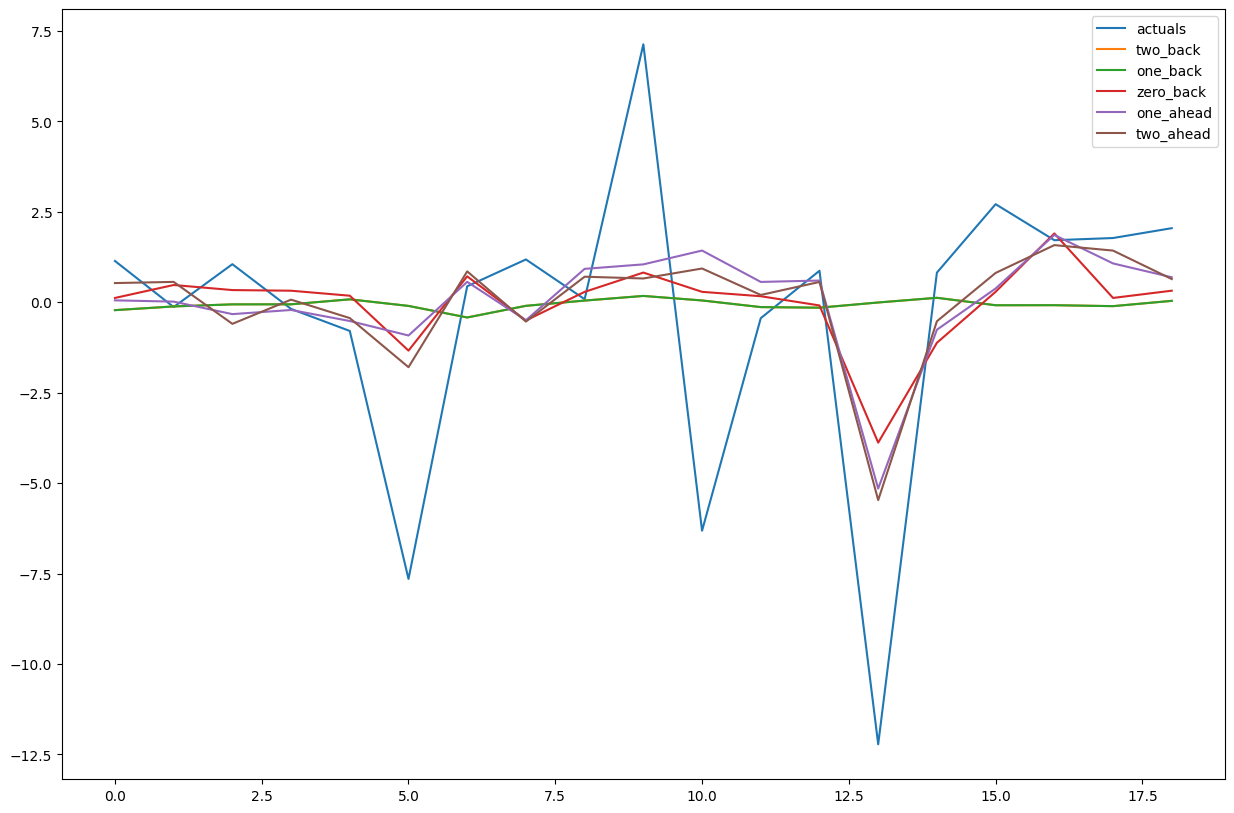

In [42]:
evaluate_lstm(data = data, target_variable='taxes', model_params=taxes_opt, plot=1, save=1)